# Assignment 1: MLPs and Backpropagation
### <font color='blue'> Due on November 4, 2022 (23:59:59) </font>

Welcome to Comp541: Deep Learning Course! 

Before you start, make sure you read the README.txt in the same directory as this notebook for important setup information. A lot of code is provided in this notebook, and we highly encourage you to read and understand it as part of the learning.

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

In [1570]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /home/cangozpi/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*. 

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In this case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](./imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [1571]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [1572]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [1573]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    # Flatten list of lists
    corpus_flattened = [word for sentence in corpus for word in sentence]
    # Remove repeating words from the corpus
    corpus_words = list(sorted(set(corpus_flattened)))
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

In [1574]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors.


In [1575]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    # ------------------
    # Write your implementation here.
    # Initialize M matrix as np.array
    M = np.zeros((num_words, num_words), dtype=np.int64) # --> [num_words, num_words]
    
    # Initialize word2ind
    for i, w in enumerate(words):
        word2ind[w] = i    
    
    # Extract context words and update M
    for sentence in corpus:
        for i, word in enumerate(sentence):
            # Extract context words for the current word
            left_context_end_ind = (i-window_size) if (i-window_size) >= 0 else 0
            right_context_end_ind = (i+1+window_size) if (i+1+window_size) <= len(sentence) else len(sentence)
            
            if i != 0: # if w is the left most word then there is no left_context
                left_context = sentence[left_context_end_ind:i]
                
                # Update co_occurrence matrix for the left_context
                for l_w in left_context:
                    ind_i = word2ind[word]
                    ind_j = word2ind[l_w]
                    M[ind_i, ind_j] = M[ind_i, ind_j] + 1
                
            if i != (len(sentence) - 1): # if w is the right most word then there is no right_context
                right_context = sentence[(i+1):right_context_end_ind]
                
                # Update co_occurrence matrix for the right_context
                for r_w in right_context:
                    ind_i = word2ind[word]
                    ind_j = word2ind[r_w]
                    M[ind_i, ind_j] = M[ind_i, ind_j] + 1

    # ------------------

    return M, word2ind

In [1576]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [1577]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    M_reduced = svd.fit_transform(M)
    # ------------------

    print("Done.")
    return M_reduced

In [1578]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [1579]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for w in words:
        w_ind = word2ind[w]
        
        w_vector = M_reduced[w_ind] # --> [k,]
        x = w_vector[0]
        y = w_vector[1]
        
        eps = 0.0
        
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x+eps, y+eps, w, fontsize=9)
    plt.show()
    
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


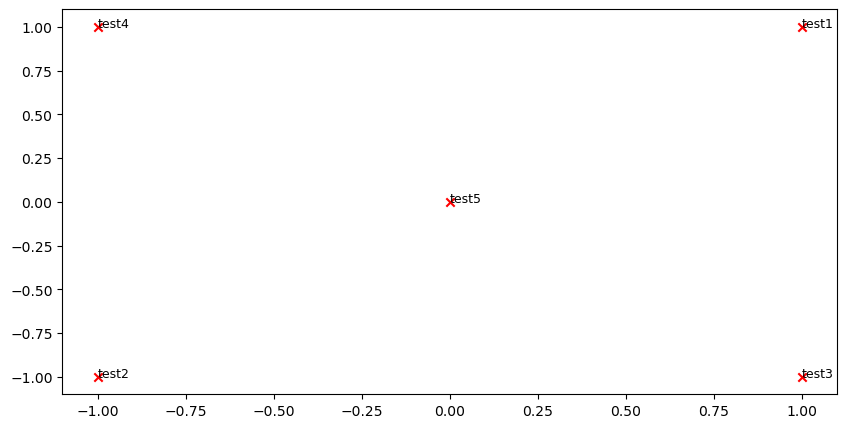

--------------------------------------------------------------------------------


In [1580]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="./imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


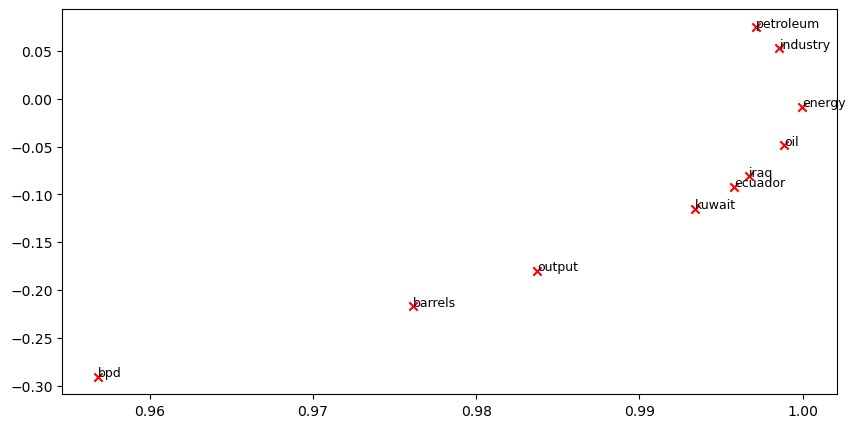

In [1581]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>
#### <font color="green">Semantically similar words seem to be clustering together in the 2-dimensional embedding space. For example, countries are clustered together such as 'iraq', 'ecuador', 'kuwait'. Also, the words 'oil' and 'energy' are located near to each other which makes sense since oil is a type of energy resource. On the other hand, I think 'energy' and 'industry' should have been closer to each other since 'energy' is a type 'industry' (i.e. energy industry). Also, I think 'oil' and 'barrels' should have been clustered together too since barrel contains oil and therefore they are related which could have been reflected in their word embeddings by being clustered together.</font>


## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [1582]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [1583]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download. 

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [1584]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [1585]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?

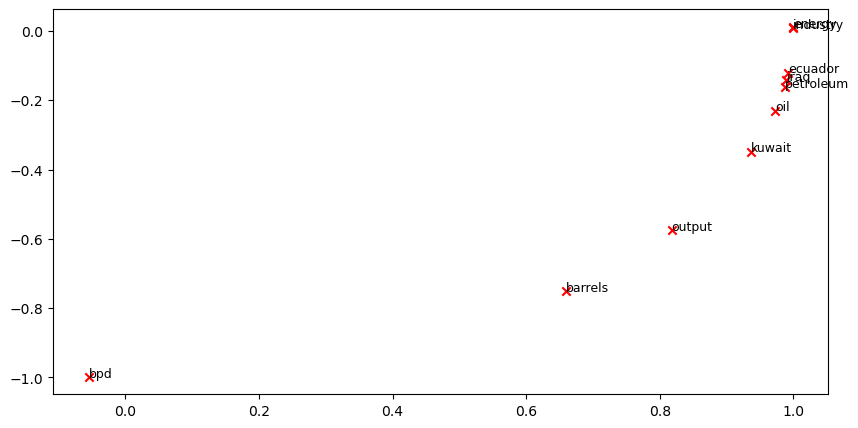

In [1586]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

#### <font color="red">Write your answer here.</font>
#### <font color="green">Semantically similar words seem to be clustering together in the 2-dimensional embedding space. For example, countries are clustered together such as 'iraq', 'ecuador', 'kuwait'. Also, the words 'oil' and 'petroleum' are located near to each other which makes sense since oil is a type of energy resource. 'energy' and 'industry' are clustered which makes sense since energy is a type of industry (i.e. energy industry).On the other hand, I think 'kuwait' and ['ecuador', 'iraq'] should have been closer to each other since 'kuwait' is a country too. Also, like ['ecuador', 'iraq'] 'kuwait' also has oil reserves in their land which makes them further semantically related which should have resulted in similar word embeddings. On the other hand, I think 'oil' and 'barrels' should have been clustered together too since barrel is a container for oil and therefore they are related which could have been reflected in their word embeddings by being clustered together. The plot is different from the one generated earlier from the co-occurrence matrix by encapsulating semantic meanings of certain words better regarding the word embedding vectors. For instance, the embedding vectors of the words 'energy' and 'industry' are more similar in this plot in comparison to the earlier one. This is an improvement since these words are semantically related (i.e. energy industry). Moreover, 'petroleum' is embedded closer to the word 'oil' which makes sense since petroleum is a product of oil. Whereas in the earlier plot these word embeddings were further apart which implies that this semantic relationship was not captured as successfully in the earlier plot as it is captured in the latest (this) plot. One possible cause of this difference could be that the documents that were used to learn these embeddings were different for the two algorithms. For example, the number of sentences and the context of words could be different between the documents used to learn these embedding which would impact the learned word embeddings. Also, the algorithms used to learn these embedding are different which could have a huge impact on the learned embeddings. For example, co-occurrence matrix could struggle to embed the second meanings of words whereas GloVe embeddings might achieve to embed more than one meanings of a word.</font>

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written] 
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. 

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [1587]:
# ------------------
# Write your implementation here.
wv_from_bin.most_similar('mouse')
    
# ------------------

[('mice', 0.6580957770347595),
 ('keyboard', 0.5548278093338013),
 ('rat', 0.5433950424194336),
 ('rabbit', 0.5192376375198364),
 ('cat', 0.5077415108680725),
 ('cursor', 0.5058691501617432),
 ('trackball', 0.5048903226852417),
 ('joystick', 0.49841052293777466),
 ('mickey', 0.47242844104766846),
 ('clicks', 0.4722805321216583)]

#### <font color="red">Write your answer here.</font>
#### <font color="green">The word I discovered is: 'mouse'. It's first meaning is: "a small furry animal with a pointed nose and a long tail that lives in people’s houses or in fields". Its another meaning that occured is "a small object that you move with your hand to give instructions to a computer". I think that many words I tried did not work because the documents used to learn these words did not have sufficient or any examples of the word being used with its other meanings. Since we are learning these embeddings from data, if these meanings are not represented in the trainign data then we cannot expect out word embeddings to encompass those left out meanings of the words. Furthermore, the algorithm used to learn these word embeddings could be not capable of embedding more than one meaning of a word. 
</font>

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$. 

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [1588]:
# ------------------
# Write your implementation here.
def check_constraint(w1, w2, w3):
    syn_dist = wv_from_bin.distance(w1, w2)
    ant_dist = wv_from_bin.distance(w1, w3)

    assert ant_dist < syn_dist, "Constraint not satisfied. Try different words."
    if ant_dist < syn_dist:
        print(f'Congratulations. Word found is: {w1}')


w1 = 'grim'
w2 = 'horrid'
w3 = 'bright'
check_constraint(w1, w2, w3)

# ------------------

Congratulations. Word found is: grim


#### <font color="red">Write your answer here.</font>
#### <font color="green">I have found the pair $w_1$="grim", $w_2$="horrid", and $w_3$="bright". I think this might have happened because the document that the word embeddings were learned on did not represent my choice of word pairs well to allow the learned embeddings to reflect their semantic relationship. For example, in my word pairs, I think this error might have happened due to $w_3$="bright" not being used in its meaning which is the antonmy of $w_1$="grim" in the training data. Probably the training data had sentences which used $w_3$="bright" in the context where it meant "shining strongly, or with plenty of light", but not "happy and full of energy"</font>

### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [1589]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978679299354553),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889755487442017),
 ('throne', 0.5775109529495239),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318053364753723),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164471864700317)]


Let $m$, $k$, $w$, and $x$ denote the word vectors for `man`, `king`, `woman`, and the answer, respectively. Using **only** vectors $m$, $k$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `king` and the answer?

#### <font color="red">Write your answer here.</font>
#### <font color="green">The expression in which we are maximizing cosine similarity with x is $(k - m) + w$.</font>

### Question 2.5: Finding Analogies [code + written]  (1.5 points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [1590]:
# ------------------
# Write your implementation here.

pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'waiter'], negative=['man']))
# ------------------

[('waitress', 0.7147579789161682),
 ('bartender', 0.6425575017929077),
 ('receptionist', 0.5911696553230286),
 ('hairdresser', 0.5214430689811707),
 ('housekeeper', 0.5071993470191956),
 ('waiters', 0.5048622488975525),
 ('hostess', 0.5042896270751953),
 ('busboy', 0.5027108192443848),
 ('barmaid', 0.5009714365005493),
 ('waitresses', 0.4968399107456207)]


#### <font color="red">Write your answer here.</font>
#### <font color="green">The analogy is man:waiter :: woman:waitress. Explanation: waiter and waitresses do the same jobs in which the only difference is that waiter implies the one doing the job is a man whereas, waitress implies the one doing the job is a woman.</font>

### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [1591]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['horse', 'shoe'], negative=['man']))

# ------------------

[('horses', 0.4861261248588562),
 ('shoes', 0.4844348728656769),
 ('footwear', 0.4807221293449402),
 ('harness', 0.4557029604911804),
 ('thoroughbred', 0.4398704767227173),
 ('stables', 0.423513799905777),
 ('saddle', 0.4221404194831848),
 ('bicycle', 0.4104623794555664),
 ('sneaker', 0.4095207452774048),
 ('laces', 0.40818917751312256)]


#### <font color="red">Write your answer here.</font>
#### <font color="green">The analogy that does not hold is man:shoe :: horse:horseshoe. Incorrect value of b according to the word vectors is: 'horses'</font>

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [1592]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375864148139954),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321308374404907),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572292804718)]

[('workers', 0.611325740814209),
 ('employee', 0.5983108878135681),
 ('working', 0.5615329146385193),
 ('laborer', 0.5442320704460144),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278827548027039),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.505452036857605),
 ('factory', 0.4940453767776489)]


#### <font color="red">Write your answer here.</font>
#### <font color="green">The difference between the list of female-associated words and the list of male-associtated words is that they are biased which can be dangerous. For example, female-associated words include 'nurse' but not doctor which implies that woman are mostly not doctors but nurses who help them. Also, they are 'teacher' which is a job mostly occupied by woman but it should not mean that 'woman' should be related with that gender neutral job description. Moreover, female-associated words are mostly domestic words such as 'mother', 'pregnant', 'homemaker' which seems to be implying that woman are mostly housewives and not analytical solvers. This is not the case for male-associated words since we do not see words such as 'dad', 'child', 'father'. Also, female-associated words do not include analytical professions such as 'engineer', 'mechanic', and 'doctor' whereas, male-associated words include 'mechanic', 'factory' which bears the bias that male are rational, analytical beings whereas woman lack these capabilities and generally don't occupy those professions. These gender biases are clearly reflected in the lists above with women being related to housewives, nurses but not doctors, and mechanics.</font>

### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [1593]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'kill'], negative=['man']))

# ------------------

[('pregnant', 0.60175621509552),
 ('kills', 0.5748392343521118),
 ('killing', 0.5688517093658447),
 ('abduct', 0.5524265170097351),
 ('killed', 0.5416921377182007),
 ('marry', 0.5254436731338501),
 ('injure', 0.5245661735534668),
 ('shoot', 0.5180408954620361),
 ('kidnap', 0.5099829435348511),
 ('suicide', 0.5027544498443604)]


#### <font color="red">Write your answer here.</font>
#### <font color="green">The above example showcases the bias that man kill and start wars whereas, women give birth (bring life) and nourish. We see this implied with 'pregnant' being returned for woman instead of some act which inflicts harm on another. In here 'kill' is a gender neutral verb but the word embeddings seems to apply that 'kill' belongs to 'man' like 'pregnant' belongs to 'woman'.</font>

### Question 2.9: Thinking About Bias [written] (2 points)

Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?

#### <font color="red">Write your answer here.</font>
#### <font color="green"> Bias gets into the word vectors from the training data that is used to learn these embedding vectors. In other words, the gender-neutral terms acquire stereotype and bias due to the context in which they are present in the corpus. For instance, if we use sentences gathered from the internet (such as tweets), it is likely that these sentences would be reflecting the biases of the ones who published those sentences on the internet. As a results the dataset would have biased training data which would result in embedding word vectors reflecting those biases that were apparent in the training data. To test or measure this source of bias, one can use pre-known sets that define the concept of gender itself and other sets that include gender specific words for both male and female. Then using these sets one can calculate the distance between gender specific words both for male and female to the gender neutral words and see if embedding vectors are biased. This would give an idea of the present gender bias/stereotypes in the embedding vectors but a similar technique could be applied to get other types of biases too with different sets. In other words, a process which allows us to measure the diversion between the neutral words component of neutral word embedding and its gender direction can be used to measure this bias.</font>

## Part 3: Sentiment Analysis (15 points)

Lastly, you will implement a simple sentiment classifier from scratch by using the Deep Averaging Network (DAN) proposed in the [paper](https://aclanthology.org/P15-1162.pdf). The model is based on the following three steps:

- Take the vector average of the embeddings associated with the words in the inputs
- Pass that average vector through one or more feed-forward layers
- Perform linear classification on the final layer’s representation


Here, you will use Stanford Sentiment Treebank (SST) dataset but note that in this dataset, the sentiment levels are originally represented with real values. Hence, you need to discretize these values into the following five classes:


- 0: "very negative" ($\le 0.2$),
- 1: "negative" ($\le 0.4$), 
- 2: "neutral" ($\le 0.6$), 
- 3: "positive" ($\le 0.8$), 
- 4: "very positive" ($>$ 0.8)

You can download the dataset [here](https://nlp.stanford.edu/sentiment/) (Download the "**Main zip file with readme (6mb)**" version). Please read `README.txt` in details, that comes with the .zip folder.

**Create a /data directory to store your SST data and unzip your downloaded folder there.** Your data path should be like following:

```
./comp541-441/assignment1/data
                            └── stanfordSentimentTreebank
                                ├── README.txt
                                ├── SOStr.txt
                                ├── STree.txt
                                ├── datasetSentences.txt
                                ├── datasetSplit.txt
                                ├── dictionary.txt
                                ├── original_rt_snippets.txt
                                └── sentiment_labels.txt
```

In your experiments, perform the following experiments and explain your findings:

- Provide your loss curves by plotting them clearly,
- Play with the number of layers,
- Try with embeddings trained on different corpuses

In [1594]:
# ------------------
# Start your implementation here.
import torch
import random
import numpy as np

def set_seed(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [1595]:
set_seed(42) # set seed for reproducibility
verbose = True

In [1596]:
# ====================== Pretrained Word Embeddings: ======================

In [1597]:
def load_and_return_word_embeddings(embedding_name = "glove-wiki-gigaword-200", size=400000):
    """
    Inputs:
        embedding_name (str): embedding to load using api.load()
        size (int): number of word embeddings to sample from the pre trained word embeddings
    Returns:
        M: numpy matrix shape (num words, 200) containing the vectors
        word2ind: dictionary mapping each word to its row number in M 
    """
    # Load Pre trained Word Embedding Vectors
    def load_embedding_model(embedding_name):
        """ Load GloVe Vectors
            Return:
                wv_from_bin: All 400000 embeddings, each lengh 200
        """
        import gensim.downloader as api
        wv_from_bin = api.load(embedding_name)
        print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
        return wv_from_bin
    
    wv_from_bin = load_embedding_model(embedding_name)
    
    
    def get_matrix_of_vectors(wv_from_bin, size):
        """ Put the GloVe vectors into a matrix M.
            Param:
                wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
                size: number of word embeddings to sample from the pre trained word embeddings
            Return:
                M: numpy matrix shape (num words, 200) containing the vectors
                word2ind: dictionary mapping each word to its row number in M
        """
        import random
        words = list(wv_from_bin.vocab.keys())
        print("Shuffling words ...")
        random.seed(224)
        random.shuffle(words)
        words = words[:size]
        print("Putting %i words into word2ind and matrix M..." % len(words))
        word2ind = {}
        M = []
        curInd = 0
        for w in words:
            try:
                M.append(wv_from_bin.word_vec(w))
                word2ind[w] = curInd
                curInd += 1
            except KeyError:
                continue
        M = np.stack(M)
        print("Done.")
        return M, word2ind
    
    M, word2ind = get_matrix_of_vectors(wv_from_bin, size) # max_size = 400_000 for glove
    return M, word2ind

In [1598]:
# embedding_names with glove trained on different corpuses
embedding_name_list = ["glove-wiki-gigaword-200", "glove-twitter-200"]
chosen_embedding_name = embedding_name_list[0]

In [1599]:
M, word2ind = load_and_return_word_embeddings(embedding_name = chosen_embedding_name, size=400000)
# Sample usage :
# M[word2ind['happy']] = word embedding for 'happy'

Loaded vocab size 400000
Shuffling words ...
Putting 400000 words into word2ind and matrix M...
Done.


In [1600]:
# ====================== Dataset Loading(HuggingFace): ======================

In [1601]:
!pip install datasets

In [1602]:
def get_preprocessed_dataset(verbose=True):
    def load_dataset_from_huggingface():
        # Load Preprocessed Dataset from Huggingface. For further info: https://huggingface.co/datasets/SetFit/sst5
        from datasets import load_dataset

        dataset = load_dataset("SetFit/sst5")
        dataset = dataset.remove_columns("label_text")
        if verbose:
            print('\nSample row of unprocessed training data: \n', dataset['train'][0])
        return dataset
    
    dataset = load_dataset_from_huggingface()
    
    
    # Preprocess text data (split words, lower case, remove punctuation, remove stop words):
    # Text Preprocessing helper function
    def get_preprocessed_text(data):
        """
        Given dict with key: 'text' holding sentence as string, preprocesses the text inside it and returns list of preprocessed words (split words, lower case, remove punctuation, remove stop words)
        Input:
            data (dict): dictionary with keys: 'text' and 'label'
        Output:
            data (dict): dict with preprocessed 'text' value. data.keys: 'text' and 'label'. 
        """
        import re
        import string

        stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

        sentence = data['text']
        exp = r'\W+'
        words = re.split(exp, sentence)
        # remove punctuation, convert to lower case, remove stop words
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table).lower() for w in words if w not in stopwords] # type = list
        data['text'] = stripped
        return data

    dataset = dataset.map(get_preprocessed_text)
    if verbose:
        print('\nSample row of training data after preprocessing sentences: \n', dataset['train'][0])
    
    return dataset

In [1603]:
dataset = get_preprocessed_dataset(verbose)

Using custom data configuration SetFit--sst5-d2e5c627328623df
Found cached dataset json (/home/cangozpi/.cache/huggingface/datasets/SetFit___json/SetFit--sst5-d2e5c627328623df/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/cangozpi/.cache/huggingface/datasets/SetFit___json/SetFit--sst5-d2e5c627328623df/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-3962d4a8b5e570e5.arrow
Loading cached processed dataset at /home/cangozpi/.cache/huggingface/datasets/SetFit___json/SetFit--sst5-d2e5c627328623df/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-9bd41474a0bda42d.arrow
Loading cached processed dataset at /home/cangozpi/.cache/huggingface/datasets/SetFit___json/SetFit--sst5-d2e5c627328623df/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-7fd99a57dfbadd64.arrow



Sample row of unprocessed training data: 
 {'text': 'a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'label': 4}

Sample row of training data after preprocessing sentences: 
 {'text': ['stirring', 'funny', 'finally', 'transporting', 'imagining', 'beauty', 'beast', '1930s', 'horror', 'films'], 'label': 4}


In [1604]:
# Checkout processed dataset
if verbose:
    print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8544
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2210
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1101
    })
})


In [1605]:
# Parameters
dropout_p = 0.3 # probability of dropping a word vector
input_dim = 200 # dimension of the word embedding vectors

In [1606]:
import torch
from torch.utils.data import DataLoader
from datasets import Features

# Converts words to corresponding word embedding vectors, and applies dropout regularization on words of the sentence
def collate_fn_dropout_regularization(batch):
    B = len(batch)
    new_batch = {}
    new_batch['label'] = torch.zeros((B), dtype=torch.int64) # placeholder values
    new_batch['averaged_vector'] = torch.zeros((B, input_dim), dtype=torch.float32) # placeholder values
    
    for cur_index, e in enumerate(batch):
        # Convert sentence in 'text' to average of its word embeddings
        # Word Embeddings preprocessing helper function
        def preprocess_text_embeddings(data):
            """
            Maps sentences to averaged sum of word embedding vectors according to word2ind and M.
            Input:
                data (dict): dictionary with keys: 'text' and 'label'
            Output:
                data (dict): dict with aveeraged word embedding as 'text' value. data.keys: 'text' and 'label'. 
            """
            # Convert words to word embedding vectors
            sentence = data['text']
            mapped_sentence = [M[word2ind[w]] for w in sentence if w in word2ind]

            # Apply Dropout Regularization
            dropped_sentence = [w_embed for w_embed in mapped_sentence if random.random() <= (1 - dropout_p)]

            # Average word embeddings of the sentence (aggregation)
            if len(mapped_sentence) > 0:
                data['averaged_vector'] = np.mean(mapped_sentence, axis=0, dtype=np.float32)
            else: # handle no word in the sentence having a corresponding word embedding vector in M
                data['averaged_vector'] = np.zeros(M.shape[1])

            # Convert averaged_vector to Torch Tensor
            data['averaged_vector'] = torch.tensor(data['averaged_vector'], dtype=torch.float32)
            return data

        cur_processed_data = preprocess_text_embeddings(e)
        new_batch['averaged_vector'][cur_index, :] = cur_processed_data['averaged_vector']
        new_batch['label'][cur_index] = cur_processed_data['label']
    
    return new_batch

def get_dataloaders(dataset):
    features = Features({'averaged_vector':torch.float32, 'label': torch.int32})
    dataset.features = features

    dataset.set_format(type="torch", columns=["text", "label"])
    train_data = DataLoader(dataset['train'], batch_size=32, shuffle=True, collate_fn=collate_fn_dropout_regularization)
    val_data = DataLoader(dataset['validation'], batch_size=32, shuffle=False, collate_fn=collate_fn_dropout_regularization)
    test_data = DataLoader(dataset['test'], batch_size=32, shuffle=False, collate_fn=collate_fn_dropout_regularization)
    
    return train_data, val_data, test_data

In [1607]:
# get pytorch dataloaders from preprocessed dataset
train_data, val_data, test_data = get_dataloaders(dataset)

In [1608]:
# Check out a batch of training data
if verbose:
    sample_batch = next(iter(train_data))
    print('Sample averaged_vector:', sample_batch['averaged_vector'].shape, '\n\nSample labels:', sample_batch['label'])

Sample averaged_vector: torch.Size([32, 200]) 

Sample labels: tensor([4, 1, 2, 1, 1, 0, 1, 3, 3, 1, 4, 1, 0, 3, 2, 4, 3, 1, 2, 2, 0, 1, 2, 2,
        3, 2, 3, 3, 3, 0, 3, 1])


In [1609]:
# ====================== Building Model: ======================

In [1610]:
from torch import nn

class DAN(nn.Module):
    def __init__(self, input_dim = 200, num_classes = 5, hidden_layer_dims = [128, 64, 32]):
        super().__init__()
        # Note that, num_classes = 5 = len([very positive, positive, neutral, negative, very negative])
        # and input_dim = 200 = word embedding dimension
        
        hidden_layer_dims = [input_dim, *hidden_layer_dims, num_classes]
        
        modules = []
        for i in range(len(hidden_layer_dims)):
            if i < (len(hidden_layer_dims) - 1):
                if i == (len(hidden_layer_dims) - 2):
                    modules.append(torch.nn.Linear(hidden_layer_dims[i], hidden_layer_dims[i+1]))
                else:
                    modules.extend([torch.nn.Linear(hidden_layer_dims[i], hidden_layer_dims[i+1]), torch.nn.ReLU()])
            
        self.model = torch.nn.Sequential(
            # fc layers
            *modules,
            
            # softmax layer
            torch.nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        """
        inputs:
            x (torch.tensor) = --> [B, word_vec_dim] (i.e. [32, 200])
        returns:
            y (torch.tensor) = --> [B, num_classes] (i.e. [32, 5]). returns probability distribution over classes.
        """
        return self.model(x)

In [1611]:
# ====================== Training & Evaluating & Testing: ======================

In [1612]:
def eval_model(model_DAN, verbose):
    if verbose:
        print("============ Evaluating model ============ ")

    # Initialize
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Evaluation Loop
    # metrics to track
    eval_loss = 0
    eval_accuracy = 0

    model_DAN.eval()

    batch_loss_history = []
    batch_accuracy_history = []

    for batch in val_data:
        X = batch['averaged_vector'] # --> [B, word_vec_dim], (torch.float32)
        true_labels = batch['label'] # --> [B], (torch.int64)

        with torch.no_grad():
            # predict 
            pred_probs = model_DAN(X) # --> [B, num_classes], (torch.float32)

            # calculate loss
            loss = loss_fn(pred_probs, true_labels)

        # calculate accuracy
        pred_labels = torch.argmax(pred_probs, dim=-1).detach().cpu() # --> [B], (torch.int64)
        num_correct_preds = torch.sum(true_labels == pred_labels) 
        accuracy = 100 * (num_correct_preds / true_labels.shape[0])


        # record metrics for current batch
        batch_loss_history.append(loss.detach().cpu().numpy())
        batch_accuracy_history.append(accuracy.detach().cpu().numpy())


    # record averaged metrics 
    eval_loss = np.mean(batch_loss_history)
    eval_accuracy = np.mean(batch_accuracy_history)
    if verbose:
        print(f"validation_loss: {eval_loss}, validation_accuracy: {eval_accuracy}")
        
    return (eval_loss, eval_accuracy)

In [1613]:
def train_and_evaluate_model(input_dim, num_classes, hidden_layer_dims, lr, epochs, verbose):
    if verbose:
        print("============ Training model ============ ")
        
    # Initialize
    model_DAN = DAN(input_dim, num_classes, hidden_layer_dims)
    optimizer = torch.optim.Adagrad(model_DAN.parameters(), lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Training Loop
    # metrics to track
    train_loss_history = []
    train_accuracy_history = []
    eval_loss_history = []
    eval_accuracy_history = []


    for i in range(epochs):
        model_DAN.train()
        
        batch_loss_history = []
        batch_accuracy_history = []

        for batch in train_data:
            X = batch['averaged_vector'] # --> [B, word_vec_dim], (torch.float32)
            true_labels = batch['label'] # --> [B], (torch.int64)
            
            # predict 
            pred_probs = model_DAN(X) # --> [B, num_classes], (torch.float32)

            # calculate loss
            loss = loss_fn(pred_probs, true_labels)

            # update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy
            pred_labels = torch.argmax(pred_probs, dim=-1).detach().cpu() # --> [B], (torch.int64)
            num_correct_preds = torch.sum(true_labels == pred_labels) 
            accuracy = 100 * (num_correct_preds / true_labels.shape[0])


            # record metrics for current batch
            batch_loss_history.append(loss.detach().cpu().numpy())
            batch_accuracy_history.append(accuracy.detach().cpu().numpy())

        # evaluate updated model
        eval_loss, eval_accuracy = eval_model(model_DAN, verbose)
            
        # record metrics for current epoch
        train_loss_history.append(np.mean(batch_loss_history))
        train_accuracy_history.append(np.mean(batch_accuracy_history))
        eval_loss_history.append(eval_loss)
        eval_accuracy_history.append(eval_accuracy)
        
        if verbose:
            print(f"epoch: {i}, train_loss: {loss_history[-1]}, train_accuracy: {accuracy_history[-1]}, \
            eval_loss: {eval_loss}, eval_accuracy: {eval_accuracy}")
        
    return model_DAN, (train_loss_history, train_accuracy_history), (eval_loss_history, eval_accuracy_history)

In [1614]:
def test_model(model_DAN, verbose):
    if verbose:
        print("============ Testing model ============ ")

    # Initialize
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Testing Loop
    # metrics to track
    test_loss = 0
    test_accuracy = 0

    model_DAN.eval()

    batch_loss_history = []
    batch_accuracy_history = []

    for batch in test_data:
        X = batch['averaged_vector'] # --> [B, word_vec_dim], (torch.float32)
        true_labels = batch['label'] # --> [B], (torch.int64)

        with torch.no_grad():
            # predict 
            pred_probs = model_DAN(X) # --> [B, num_classes], (torch.float32)

            # calculate loss
            loss = loss_fn(pred_probs, true_labels)

        # calculate accuracy
        pred_labels = torch.argmax(pred_probs, dim=-1).detach().cpu() # --> [B], (torch.int64)
        num_correct_preds = torch.sum(true_labels == pred_labels) 
        accuracy = 100 * (num_correct_preds / true_labels.shape[0])


        # record metrics for current batch
        batch_loss_history.append(loss.detach().cpu().numpy())
        batch_accuracy_history.append(accuracy.detach().cpu().numpy())


    # record averaged metrics 
    test_loss = np.mean(batch_loss_history)
    test_accuracy = np.mean(batch_accuracy_history)
    if verbose:
        print(f"test_loss: {test_loss}, test_accuracy: {test_accuracy}")
        
    return (test_loss, test_accuracy)

In [1615]:
# ====================== Fine Tuning Hyperparameters: ======================

In [1616]:
# # Hyperparameters for training
num_classes = 5
verbose_train_eval = False

# Grid-search for best pair of hyperparameters
#hidden_layer_dims_list = [
#    [128, 64],
#    [128, 64, 32],
#    [128, 64, 32, 16],
#    [256, 128],
#    [256, 128, 64],
#    [256, 128, 64, 16]
#]
#lr_list = [1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4]
#epochs_list = [10, 50, 100, 150]

# Note that code below defines a more strict search space than the commented code above.
# This is done for reducing the computational time required for running the code.
hidden_layer_dims_list = [
    [128],
    [128, 64],
    [128, 64, 32],
    [128, 64, 32, 16],
    [128, 64, 32, 16, 8]
]
lr_list = [1e-3]
epochs_list = [30]

In [1617]:
# Perform Grid Search to find the best combination of hyperparameters
best_hidden_layer_dims = None
best_lr = None
best_epochs = None
best_model_DAN = None
best_model_train_loss_history = []
best_model_train_accuracy_history = []
best_model_eval_loss_history = []
best_model_eval_accuracy_history = []

hidden_layer_search_loss_history = []
hidden_layer_search_accuracy_history = []

search_counter = 0
num_searches = len(hidden_layer_dims_list) * len(lr_list) * len(epochs_list)
for hidden_layer_dims in hidden_layer_dims_list:
    for lr in lr_list:
        for epochs in epochs_list:
            # Train& Evaluate Model
            model_DAN, train_metrics, eval_metrics = train_and_evaluate_model(input_dim, num_classes, hidden_layer_dims, lr, epochs, verbose_train_eval)
            train_loss_history, train_accuracy_history = train_metrics
            eval_loss_history, eval_accuracy_history = eval_metrics
            
            # Evaluate Model
            #eval_metrics = eval_model(model_DAN, verbose_train_eval)
            #eval_loss, eval_accuracy = eval_metrics
            
            # Check for best hyperparameters
            if len(best_model_eval_loss_history) == 0:
                best_hidden_layer_dims = hidden_layer_dims
                best_lr = lr
                best_epochs = epochs
                best_model_DAN = model_DAN
                best_model_train_loss_history = train_loss_history
                best_model_train_accuracy_history = train_accuracy_history
                best_model_eval_loss_history = eval_loss_history
                best_model_eval_accuracy_history = eval_accuracy_history
            elif eval_loss_history[-1] < best_model_eval_loss_history[-1]:
                best_hidden_layer_dims = hidden_layer_dims
                best_lr = lr
                best_epochs = epochs
                best_model_DAN = model_DAN
                best_model_train_loss_history = train_loss_history
                best_model_train_accuracy_history = train_accuracy_history
                best_model_eval_loss_history = eval_loss_history
                best_model_eval_accuracy_history = eval_accuracy_history
                
            search_counter += 1
            print(f'Performing hyperparameters search: {search_counter}/{num_searches} ...')
    
    # Record eval metrics for different hidden_layer depths
    hidden_layer_search_loss_history.append(eval_loss_history[-1])
    hidden_layer_search_accuracy_history.append(eval_accuracy_history[-1])
            
            

# Test best Model
test_metrics = test_model(best_model_DAN, verbose_train_eval)
best_model_test_loss, best_model_test_accuracy = test_metrics


print('-'*50, f'\nBest found DAN Model: \n\tbest_train_loss: {best_model_train_loss_history[-1]}\
\n\tbest_eval_loss: {best_model_eval_loss_history[-1]}\
\n\tbest_test_loss: {best_model_test_loss}\
\n\tbest_train_accuracy: {best_model_train_accuracy_history[-1]}\
\n\tbest_eval_accuracy: {best_model_eval_accuracy_history[-1]}\
\n\tbest_test_accuracy: {best_model_test_accuracy}\
\n\tbest_hidden_layer_dims: {best_hidden_layer_dims}\
\n\tbest_lr: {best_lr}\
\n\tbest_epochs: {best_epochs}\
\n', '-'*50)

Performing hyperparameters search: 1/5 ...
Performing hyperparameters search: 2/5 ...
Performing hyperparameters search: 3/5 ...
Performing hyperparameters search: 4/5 ...
Performing hyperparameters search: 5/5 ...
-------------------------------------------------- 
Best found DAN Model: 
	best_train_loss: 1.4908462762832642
	best_eval_loss: 1.5066484212875366
	best_test_loss: 1.4927891492843628
	best_train_accuracy: 40.203651428222656
	best_eval_accuracy: 37.30769348144531
	best_test_accuracy: 40.04464340209961
	best_hidden_layer_dims: [128, 64, 32, 16, 8]
	best_lr: 0.001
	best_epochs: 30
 --------------------------------------------------


In [1618]:
# ====================== Plot Best Results: ======================

In [1619]:
import matplotlib.pyplot as plt

def plot_results():
    plt.figure(figsize=(10,4))

    # plot loss & accuracy curves
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(best_model_train_loss_history)), best_model_train_loss_history, label="training loss")
    plt.plot(np.arange(len(best_model_eval_loss_history)), best_model_eval_loss_history, label="evaluation loss")
    plt.title('Loss Curves')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(best_model_train_accuracy_history)), best_model_train_accuracy_history, label="training accuracy")
    plt.plot(np.arange(len(best_model_eval_accuracy_history)), best_model_eval_accuracy_history, label="evaluation accuracy")
    plt.title('Accuracy Curves')
    plt.xlabel('epoch')
    plt.ylabel('accuracy (%)')
    plt.legend()

    plt.show()
    
    
    # plot hidden_dim depth search results
    plt.figure(figsize=(10,4))
    
    plt.subplot(1, 2, 1)
    plt.scatter(np.arange(len(hidden_layer_search_loss_history)), hidden_layer_search_loss_history)
    plt.title('Hidden Layer Depth Loss Results')
    plt.xlabel('depth (number of layers)')
    plt.ylabel('loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(np.arange(len(hidden_layer_search_accuracy_history)), hidden_layer_search_accuracy_history)
    plt.title('Hidden Layer Depth Accuracy Results')
    plt.xlabel('depth (number of layers)')
    plt.ylabel('accuracy (%)')
    plt.legend()
    

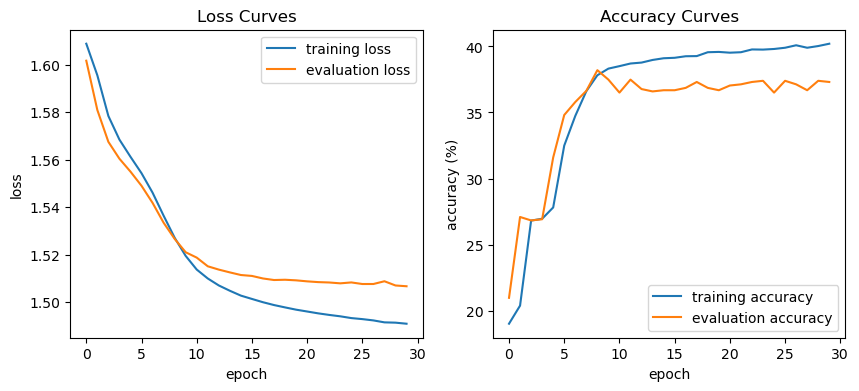

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


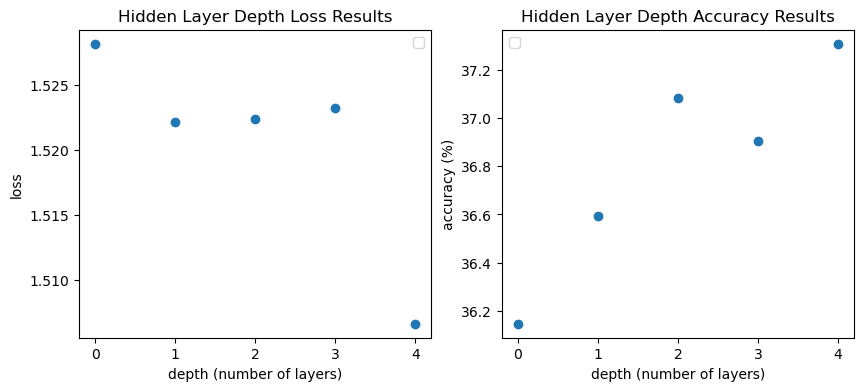

In [1620]:
plot_results()

In [1621]:
# ====================== Discussion of Results: ======================

### Discussion of Results:
I have performed grid search on some hyperparameters I chose to find the best set of hyperparameters out of those. 

My findings indicate that the best set is:

    * lr: 1e-2
    * epochs: 30
    * hidden layer depth: 2
    * pretrained word embeddings: 'glove-wiki-gigaword-200'
    * dropout_p = 0.3 # probability of dropping a word vector
---

I chose lr:1e-2 since it seemed to be the best trade-off between training speed and accuracy.
I chose to train for 30 epochs because I observed that the evaluation loss saturates around 30 epochs. Afterwards, the model starts to overfit the training data which hurts its generalization and its performance on the test data.
I have experimented with hidden layer depths. Generally it seems to be indicating that increasing the depth could potentially yield better performance. On the other hand, increasing the depth increases computational complexity of the model and results in longer training times. I found that 2 hidden layers (depth 2) seems to be the sweep spot for my purposes.
Since there are 5 classes, a random model would be 20% accurate. Seeing that our trained model yields higher accuracies indicates that model is doing better than randomly guessing. Also, reduction in the loss values along with increased accuracy indicates that model is indeed learning from data.
We see that evaluation loss saturates (stops reducing), and training loss continues to decrease. This indicates that model is starting the overfit the training data when it is trained for longer epochs. To prevent this I have chosen epoch number which is around the epoch value that model start to overfit.
I have trained on the dataset and picked the best pair of hyperparameters according to its performance on the evaluation dataset.
I have tested the best chosen set of hyperparameters performance on the test dataset.
I have checked pretrained word embeddings ["glove-wiki-gigaword-200", "glove-twitter-200"]. My experiments
can be replicated by changing the value of 'chosen_embedding_name' variable to point one of these values.
These word embeddings are trained on different corpuses (Twitter, Wikipedia). Word embeddings trained on wikipedia
yielded the best results for the hyperparameters I have chosen. The results show that the corpus which the word
embeddings are trained on does make a difference.
Finally, the dropout regularization applied to the words in the sentences seem to perform best with dropout probability set to 0.3. Intuitively this custom dropout idea makes sense since, it should allow model to see more sentences during training by taking different combinations of the words from the given sentences. On the other hand, it did not improve the performance significantly when compared to the performance of the model trained by not using dropout.

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells). 
3. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
4. Download a .ipynb version of your notebook, please name this as username_assignment1.ipynb and submit it to Blackboard by the deadline.

*This assignment is adapted from Stanford [CS224n](http://web.stanford.edu/class/cs224n/)*